## Ingredient Analysis on Sephora Products

In [87]:
%pip install numpy
%pip install textblob
%pip install seaborn
%pip install fuzzywuzzy

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip in

In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from textblob import TextBlob
import re
from collections import Counter, defaultdict
import difflib
from fuzzywuzzy import fuzz, process

In [98]:
df = pd.read_csv('https://raw.githubusercontent.com/r41ss4/rennes_ds/refs/heads/main/data/clust_sent/prod_clust_sent.csv')
df.head(5)

,product_id,polarity,polarity_level,intensity,aspects,product_name,brand_id,brand_name,loves_count,rating,...,out_of_stock,sephora_exclusive,highlights,primary_category,secondary_category,tertiary_category,child_count,child_max_price,child_min_price,cluster
0,P173622,0.288960,3.016667,0.656185,mask,Benefiance Pure Retinol Intensive Revitalizing...,5337,Shiseido,11355,4.4500,...,0,0,"['Layerable Scent', 'Floral Scent']",Skincare,Masks,Sheet Masks,0,53.792023,39.665802,0
1,P202935,0.266912,2.888889,0.659503,cream,Benefiance NutriPerfect Night Cream,5337,Shiseido,5520,4.4722,...,0,0,"['Good for: Anti-Aging', 'Good for: Loss of fi...",Skincare,Moisturizers,Moisturizers,0,53.792023,39.665802,5
2,P2046,0.340859,3.076923,0.586551,thi,Brumisateur Natural Mineral Water Facial Spray...,3526,Evian,10378,4.6813,...,0,0,"['Clean at Sephora', 'Hydrating']",Skincare,Moisturizers,Mists & Essences,0,53.792023,39.665802,0
3,P232920,0.251107,2.957143,0.548413,eye,Line Release Under Eye Repair Cream,5946,Kate Somerville,4556,3.9143,...,0,0,"['Layerable Scent', 'Floral Scent']",Skincare,Eye Care,Eye Creams & Treatments,0,53.792023,39.665802,5
4,P270600,0.184496,2.636364,0.301955,eye,Extra Eye Repair Cream Intense,5644,Bobbi Brown,12571,3.3636,...,0,0,"['Hydrating', 'Plumping', 'Hyaluronic Acid', '...",Skincare,Eye Care,Eye Creams & Treatments,0,53.792023,39.665802,2


In [99]:
df.isna().sum()

product_id            0
polarity              0
polarity_level        0
intensity             0
aspects               0
product_name          0
brand_id              0
brand_name            0
loves_count           0
rating                0
reviews               0
size                  0
variation_type        0
variation_value       0
variation_desc        0
ingredients           0
price_usd             0
value_price_usd       0
sale_price_usd        0
limited_edition       0
new                   0
online_only           0
out_of_stock          0
sephora_exclusive     0
highlights            0
primary_category      0
secondary_category    0
tertiary_category     0
child_count           0
child_max_price       0
child_min_price       0
cluster               0
dtype: int64

In [100]:
# extract correct ingredients for certain product from various ingredient sets
def extract_ingredient(row):
    product_name = row['product_name']
    ingredients_raw = row['ingredients']
    try:
        ingredients_list = eval(ingredients_raw) if isinstance(ingredients_raw, str) else ingredients_raw
    except:
        return None
    if not isinstance(ingredients_list, list):
        return ingredients_raw
    if any(':' in str(s) for s in ingredients_list):
        for i, item in enumerate(ingredients_list):
            if isinstance(item, str) and ':' in item:
                product_header = item.replace(':', '').strip()
                if product_header.lower() in product_name.lower():
                    return ingredients_list[i + 1] if i + 1 < len(ingredients_list) else None
        return None
    else:
        return ingredients_raw

# assign to new dataset
df_cleaned = df.copy()
df_cleaned['cleaned_ingredients'] = df_cleaned.apply(extract_ingredient, axis=1)
df_cleaned = df_cleaned.dropna(subset=['cleaned_ingredients']).reset_index(drop=True)

In [101]:
# clean ingredient names
def smart_split_ingredients(ingredient_str):
    ingredient_str = re.sub(r'^\[|\]$', '', str(ingredient_str).strip())
    raw_parts = [i.strip() for i in ingredient_str.split(',') if i.strip()]
    
    fixed_ingredients = []
    buffer = ""
    for part in raw_parts:
        clean_part = re.sub(r"^[\"'‘’]+|[\"'‘’]+$", '', part.strip().lower())
        if len(clean_part) < 3:
            buffer += clean_part + ','
        else:
            if buffer:
                full_part = buffer + clean_part
                buffer = ""
            else:
                full_part = clean_part
            fixed_ingredients.append(full_part)

    # remove duplicated ingredients from one product        
    return list(set(fixed_ingredients))

In [102]:
# define standardized dict
standardize_dict = {
    'tocopherol': 'vitamin e',
    'tocopheryl acetate': 'vitamin e',
    'ascorbic acid': 'vitamin c',
    'sodium hyaluronate': 'hyaluronic acid',
    'hyaluronate': 'hyaluronic acid',
    'glycerine': 'glycerin',
    'glycerin': 'glycerin',
    'aqua': 'water',
    'eau': 'water',
    'parfum': 'fragrance',
    'fragrance (parfum)': 'fragrance',
    'disodium edta': 'edta',
    'tetrasodium edta': 'edta',
    'limonene': 'fragrance compound',
    'linalool': 'fragrance compound',
}

# fuzzy matching
def fuzzy_standardize(ingredient, dictionary):
    best_match = process.extractOne(ingredient, dictionary.keys(), scorer=fuzz.partial_ratio)
    if best_match and best_match[1] >= 85:
        return dictionary[best_match[0]]
    return ingredient

def clean_and_standardize(ingredient_str):
    split_list = smart_split_ingredients(ingredient_str)
    return list(set([fuzzy_standardize(i, standardize_dict) for i in split_list]))

# assign new ingredient list to dataset
ingredient_lists = df_cleaned['cleaned_ingredients'].apply(clean_and_standardize)
df_cleaned['final_ingredient_list'] = ingredient_lists.apply(lambda lst: ', '.join(lst))


/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/184782427.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ingredient_df, x='count', y='ingredient', palette='magma')
/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/184782427.py:13: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/184782427.py:13: UserWarning: Glyph 29694 (\N{CJK UNIFIED IDEOGRAPH-73FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/184782427.py:13: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/18478242

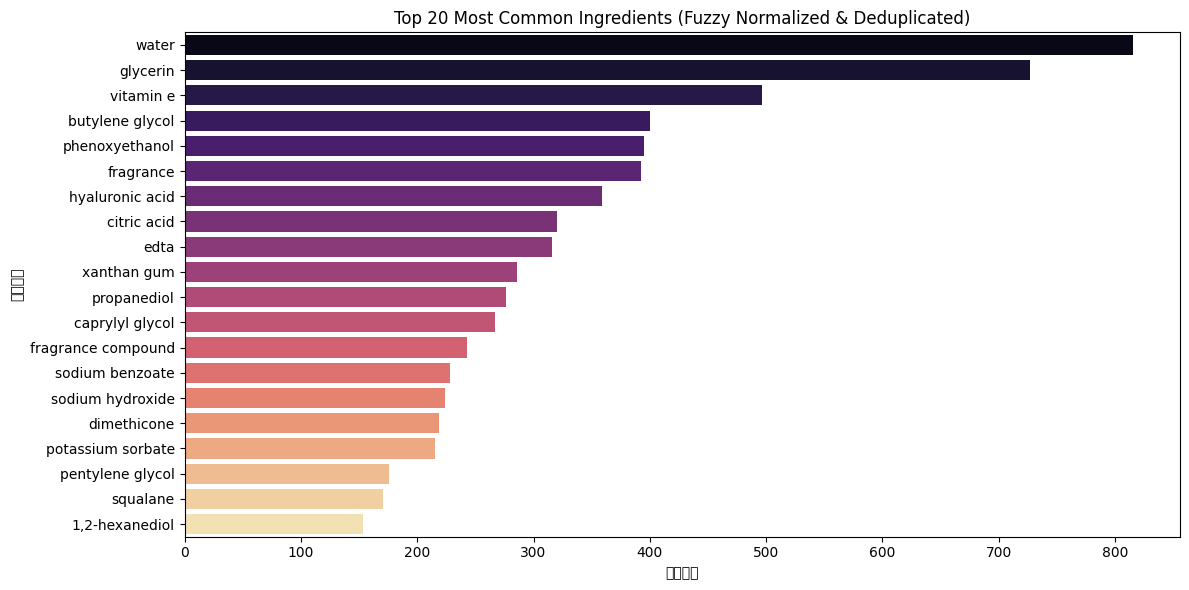

In [103]:
# calculate the most common ingredients
all_ingredients = [i for sublist in ingredient_lists for i in sublist]
ingredient_counts = Counter(all_ingredients)
common_ingredients = ingredient_counts.most_common(20)

# plot the figure
ingredient_df = pd.DataFrame(common_ingredients, columns=['ingredient', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(data=ingredient_df, x='count', y='ingredient', palette='magma')
plt.title("Top 20 Most Common Ingredients (Fuzzy Normalized & Deduplicated)")
plt.xlabel("出現次數")
plt.ylabel("成分名稱")
plt.tight_layout()
plt.show()


### Analyze the Ingredients between High-Polarity and Low-Polarity Products

In [108]:
# define the threshold of polarity
q1 = df_cleaned['polarity'].quantile(0.25)
q3 = df_cleaned['polarity'].quantile(0.75)

# define high and low polarity products
high_df = df_cleaned[df_cleaned['polarity'] >= q3]
low_df = df_cleaned[df_cleaned['polarity'] <= q1]
high_ingredients = [i for sublist in high_df['final_ingredient_list'].str.split(', ') for i in set(sublist)]
low_ingredients = [i for sublist in low_df['final_ingredient_list'].str.split(', ') for i in set(sublist)]

# calculate the difference and assign to a new dataset
high_count = Counter(high_ingredients)
low_count = Counter(low_ingredients)
all_ings = list(set(high_count.keys()).union(set(low_count.keys())))
df_diff = pd.DataFrame({
    'ingredient': all_ings,
    'high_polarity': [high_count.get(i, 0) for i in all_ings],
    'low_polarity': [low_count.get(i, 0) for i in all_ings],
})
df_diff['difference'] = df_diff['high_polarity'] - df_diff['low_polarity']

# sort value by difference
df_diff = df_diff.sort_values(by='difference', ascending=False)
df_diff

,ingredient,high_polarity,low_polarity,difference
681,fragrance,106,89,17
2457,squalane,50,37,13
2060,sodium pca,27,15,12
1824,fragrance compound,57,47,10
2211,tetrasodium glutamate diacetate,13,3,10
...,...,...,...,...
2159,silica,17,33,-16
1055,sodium hydroxide,51,67,-16
1373,caffeine,20,38,-18
1229,dimethicone,44,65,-21


In [111]:
# print the top positive and negative ingredient respectively
top_positive = df_diff[df_diff['difference'] > 0].sort_values(by='difference', ascending=False).head(6)
top_negative = df_diff[df_diff['difference'] < 0].sort_values(by='difference').head(6)

print("Common Positive Ingredients：\n", top_positive[['ingredient', 'high_polarity', 'low_polarity', 'difference']])
print("------------------------")
print("Common Negative Ingredients：\n", top_negative[['ingredient', 'high_polarity', 'low_polarity', 'difference']])

Common Positive Ingredients：
                            ingredient  high_polarity  low_polarity  difference
681                         fragrance            106            89          17
2457                         squalane             50            37          13
2060                       sodium pca             27            15          12
1824               fragrance compound             57            47          10
2211  tetrasodium glutamate diacetate             13             3          10
781                       propanediol             79            69          10
------------------------
Common Negative Ingredients：
             ingredient  high_polarity  low_polarity  difference
92      phenoxyethanol             84           106         -22
1229       dimethicone             44            65         -21
1373          caffeine             20            38         -18
1055  sodium hydroxide             51            67         -16
2159            silica             17     

/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/3332533450.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_positive, x='difference', y='ingredient', palette='Greens_r')


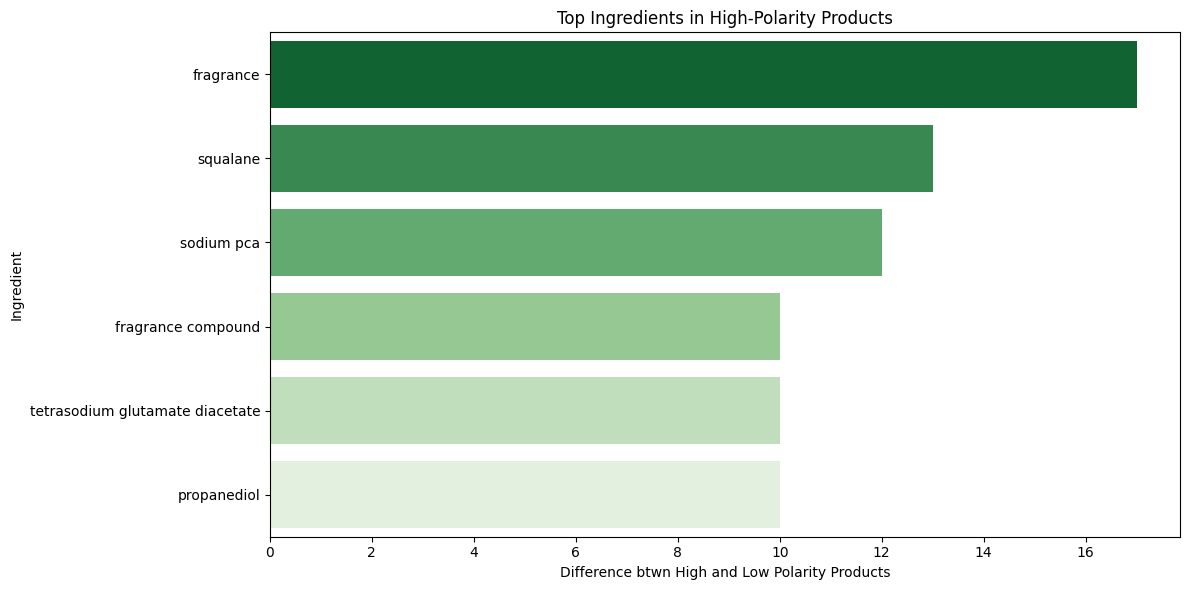

/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/3332533450.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_negative, x='difference', y='ingredient', palette='Reds')


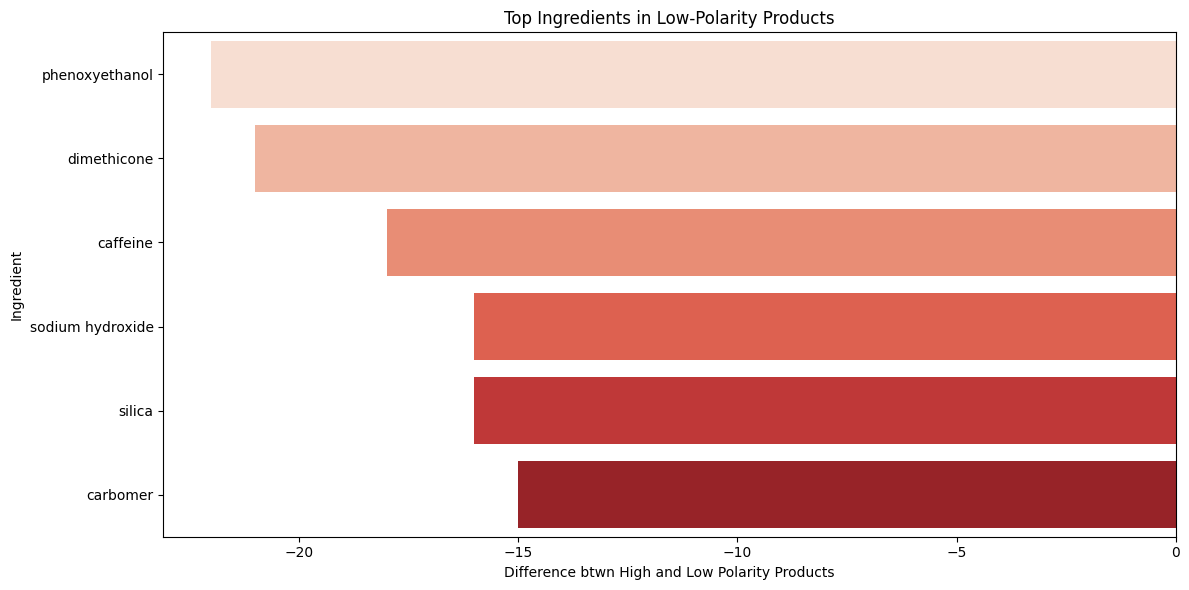

In [ ]:
# plot the figures
plt.figure(figsize=(12, 6))
sns.barplot(data=top_positive, x='difference', y='ingredient', palette='Greens_r')
plt.title("Top Ingredients in High-Polarity Products")
plt.xlabel("Difference of Count btwn High and Low Polarity Products")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=top_negative, x='difference', y='ingredient', palette='Reds')
plt.title("Top Ingredients in Low-Polarity Products")
plt.xlabel("Difference of Count btwn High and Low Polarity Products")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()


### Analyze the Ingredients between High-Pricing and Low-Pricing Products

In [119]:
# define the threshold of price
q1 = df_cleaned['price_usd'].quantile(0.25)
q3 = df_cleaned['price_usd'].quantile(0.75)

# define high and low pricing products
high_price_df = df_cleaned[df_cleaned['price_usd'] >= q3]
low_price_df = df_cleaned[df_cleaned['price_usd'] <= q1]
high_price_ings = [i for sublist in high_price_df['final_ingredient_list'].str.split(', ') for i in set(sublist)]
low_price_ings = [i for sublist in low_price_df['final_ingredient_list'].str.split(', ') for i in set(sublist)]

# calculate the difference and assign to a new dataset
high_price_count = Counter(high_price_ings)
low_price_count = Counter(low_price_ings)
all_ingredients = list(set(high_price_count.keys()).union(set(low_price_count.keys())))
df_price_diff = pd.DataFrame({
    'ingredient': all_ingredients,
    'high_price': [high_price_count.get(i, 0) for i in all_ingredients],
    'low_price': [low_price_count.get(i, 0) for i in all_ingredients],
})
df_price_diff['difference'] = df_price_diff['high_price'] - df_price_diff['low_price']

# sort value by difference
df_price_diff = df_price_diff.sort_values(by='difference', ascending=False)
df_price_diff

,ingredient,high_price,low_price,difference
728,vitamin e,162,87,75
1125,dimethicone,92,22,70
2059,butylene glycol,131,73,58
909,xanthan gum,103,47,56
846,edta,110,56,54
...,...,...,...,...
2042,allantoin,11,27,-16
1687,sodium chloride,19,35,-16
1243,propylene glycol,9,34,-25
126,hydroxyacetophenone,3,29,-26


/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/2885982288.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_high_price, x='difference', y='ingredient', palette='Greens_r')


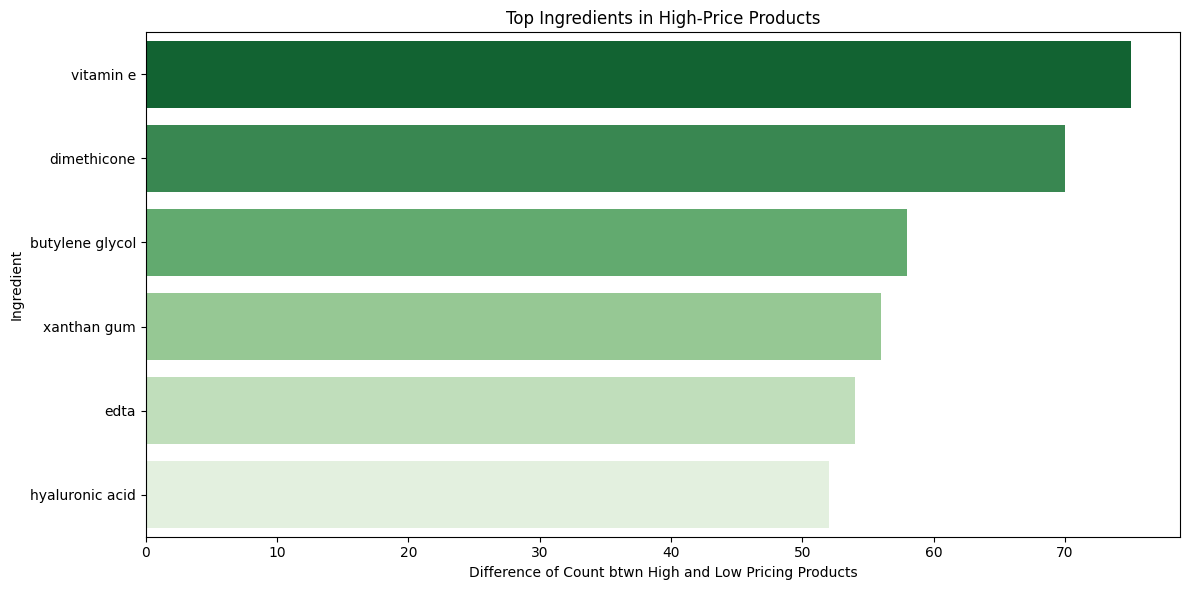

/var/folders/j7/pgkvmfjs2pv21bg0sgwm4wvm0000gn/T/ipykernel_39135/2885982288.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_low_price, x='difference', y='ingredient', palette='Reds')


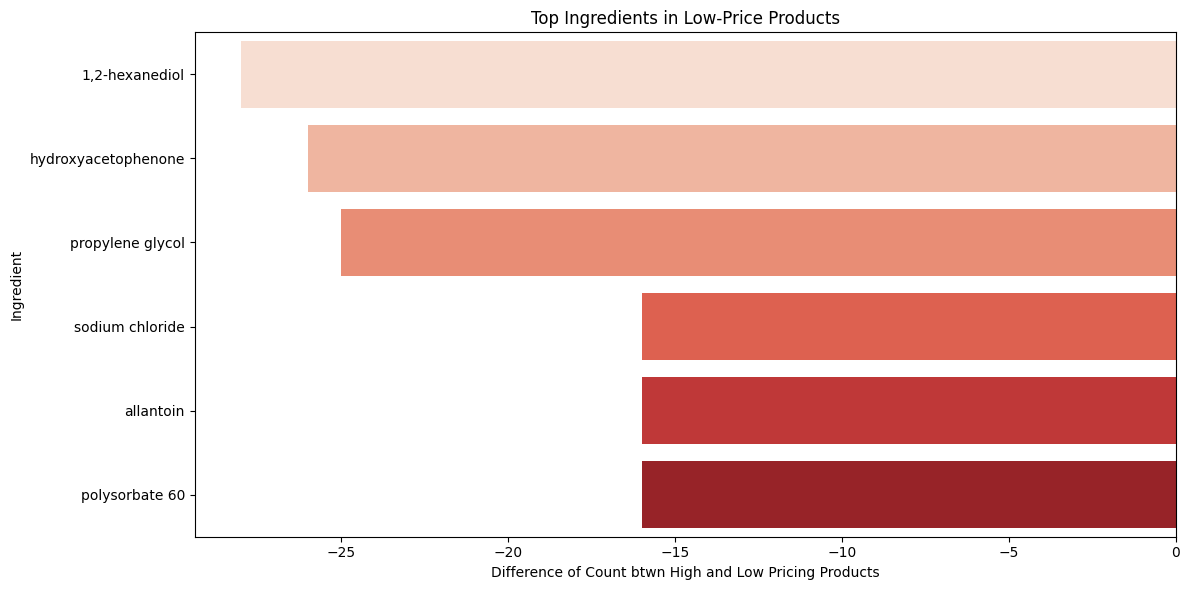

In [120]:
# the common ingredients of high pricing products
top_high_price = df_price_diff[df_price_diff['difference'] > 0].head(6)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_high_price, x='difference', y='ingredient', palette='Greens_r')
plt.title("Top Ingredients in High-Price Products")
plt.xlabel("Difference of Count btwn High and Low Pricing Products")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()

# the common ingredients of low pricing products
top_low_price = df_price_diff[df_price_diff['difference'] < 0].sort_values(by='difference').head(6)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_low_price, x='difference', y='ingredient', palette='Reds')
plt.title("Top Ingredients in Low-Price Products")
plt.xlabel("Difference of Count btwn High and Low Pricing Products")
plt.ylabel("Ingredient")
plt.tight_layout()
plt.show()